In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
transform = T.Compose([
    T.Resize((28, 28)),
    T.ToTensor()
])

omniglot_train = torchvision.datasets.Omniglot(
    root='./data', background=True, download=True, transform=transform
)


data_by_class = defaultdict(list)
for img, label in omniglot_train:
    data_by_class[label].append(img)


In [ ]:
def create_episode(n_way=5, k_shot=1, q_query=5):
    selected_classes = random.sample(list(data_by_class.keys()), n_way)
    support, query = [], []
    for i, cls in enumerate(selected_classes):
        samples = random.sample(data_by_class[cls], k_shot + q_query)
        support += [(img, i) for img in samples[:k_shot]]
        query += [(img, i) for img in samples[k_shot:]]
    return support, query

In [ ]:
#print(data_by_class)

In [ ]:
class ProtoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)


In [ ]:
def prototypical_loss(model, support, query, n_way, k_shot):
    support_x, support_y = zip(*support)
    query_x, query_y = zip(*query)

    support_x = torch.stack(support_x).to(device)
    query_x = torch.stack(query_x).to(device)
    support_y = torch.tensor(support_y).to(device)
    query_y = torch.tensor(query_y).to(device)

    emb_support = model(support_x)
    emb_query = model(query_x)

    # Tính prototype mỗi class
    prototypes = []
    for i in range(n_way):
        prototypes.append(emb_support[support_y == i].mean(0))
    prototypes = torch.stack(prototypes)

    # Khoảng cách Euclidean và loss
    dists = torch.cdist(emb_query, prototypes)
    preds = (-dists).softmax(dim=1)

    loss = nn.CrossEntropyLoss()(preds, query_y)
    acc = (preds.argmax(dim=1) == query_y).float().mean()

    return loss, acc.item(), preds.argmax(dim=1).cpu(), query_y.cpu()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProtoNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_accs = []
for episode in range(5000):
    support, query = create_episode(n_way=5, k_shot=1, q_query=5)
    loss, acc, _, _ = prototypical_loss(model, support, query, n_way=5, k_shot=1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_accs.append(acc)
    if episode % 100 == 0:
        print(f"[Episode {episode}] Loss: {loss.item():.4f}, Acc: {acc:.4f}")


[Episode 0] Loss: 1.5754, Acc: 0.4000
[Episode 100] Loss: 1.1488, Acc: 0.7600
[Episode 200] Loss: 1.2483, Acc: 0.6400
[Episode 300] Loss: 1.2293, Acc: 0.7200
[Episode 400] Loss: 1.0046, Acc: 0.9200
[Episode 500] Loss: 1.1285, Acc: 0.7600
[Episode 600] Loss: 0.9551, Acc: 0.9600
[Episode 700] Loss: 1.0643, Acc: 0.8400
[Episode 800] Loss: 1.2499, Acc: 0.6800
[Episode 900] Loss: 1.2419, Acc: 0.6400
[Episode 1000] Loss: 1.1020, Acc: 0.8000
[Episode 1100] Loss: 0.9548, Acc: 0.9600
[Episode 1200] Loss: 0.9853, Acc: 0.9600
[Episode 1300] Loss: 1.1952, Acc: 0.6800
[Episode 1400] Loss: 1.2565, Acc: 0.6400
[Episode 1500] Loss: 0.9731, Acc: 0.9600
[Episode 1600] Loss: 0.9729, Acc: 0.9200
[Episode 1700] Loss: 1.2338, Acc: 0.6400
[Episode 1800] Loss: 0.9196, Acc: 1.0000
[Episode 1900] Loss: 1.0974, Acc: 0.8000
[Episode 2000] Loss: 0.9334, Acc: 1.0000
[Episode 2100] Loss: 1.0201, Acc: 0.8800
[Episode 2200] Loss: 1.1264, Acc: 0.8000
[Episode 2300] Loss: 0.9776, Acc: 0.9600
[Episode 2400] Loss: 0.9790,

Test Accuracy: 86.92%


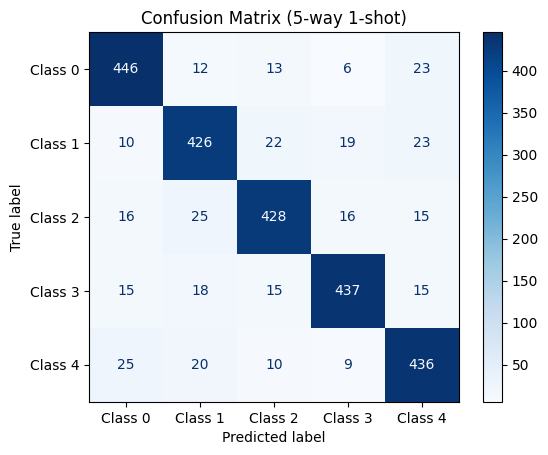

In [ ]:
model.eval()
all_preds, all_labels = [], []
test_accs = []

for _ in range(100):
    support, query = create_episode(n_way=5, k_shot=1, q_query=5)
    _, acc, preds, labels = prototypical_loss(model, support, query, n_way=5, k_shot=1)
    test_accs.append(acc)
    all_preds += preds.tolist()
    all_labels += labels.tolist()

print(f"Test Accuracy: {np.mean(test_accs)*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(5)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (5-way 1-shot)")
plt.show()
